In [4]:
%reset -f
%pylab inline
pylab.rcParams['figure.figsize'] = (12,10) # setting default figure size
pylab.style.use('ggplot') # setting style

Populating the interactive namespace from numpy and matplotlib


**Import necessary libraries**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
from datetime import datetime as dt
from pandas_datareader import data, famafrench
import wrds
import statsmodels.api as sm

S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


**Let's query out the compustat blocks**

There are two data pulls from compustat in this case, one is related to annual fundamental as defined in the first query and the next one being quarterly data for calculating the variable `evol`

The annual variable ids are as follows (without COMPUSTAT info),
- `revt, sale, cogs, at, lt, re, ebit` 
- `dp, capx, act, lct, che, dlc, dltt, txp, mib, pstkrv`
- `pstkl, pstk, pi, txditc, seq, ceq, ib, txdi, dvp, dvc`

The quarterly variable ids are as follows (without COMPUSTAT info),
- `ceqq, seqq, atq, ltq, mibq, ibq`



In [6]:
# annual fundamental data 
compa_block_query = """
                   select gvkey, datadate, revt, sale, cogs, at, lt, re,
                   dp, capx, act, lct, che, dlc, dltt, txp, mib, pstkrv,
                   pstkl, pstk, pi, txditc, seq, ceq, ib, txdi, dvp, dvc, ebit
                   from comp.funda
                   where indfmt='INDL'
                   and datafmt='STD'
                   and popsrc='D'
                   and consol='C'
                   and datadate >= '01/01/1920' and datadate <= '12/31/2020'
                   """

# quarterly fundamental data for 'evol'
compq_block_query = """
                   select gvkey, datadate, ceqq, seqq,
                   atq, ltq, mibq, ibq, txditcq, pstkq
                   from comp.fundq
                   where indfmt='INDL'
                   and datafmt='STD'
                   and popsrc='D'
                   and consol='C'
                   and datadate >= '01/01/1920' and datadate <= '12/31/2020'
                   """

#compa_df = db.raw_sql(compa_block_query)
#compq_df = db.raw_sql(compq_block_query)
#compa_df.to_pickle('compa_df.pkl')
#compq_df.to_pickle('compq_df.pkl')

compa_df = pd.read_pickle('compa_df.pkl')
compq_df = pd.read_pickle('compq_df.pkl')

compa_df[['gvkey']] = compa_df[['gvkey']].astype(int)
compa_df['datadate'] = pd.to_datetime(compa_df['datadate'])
compa_df['year_crsp'] = (compa_df['datadate'] + YearEnd(0)).dt.year
compa_df = compa_df.sort_values(by=['gvkey', 'datadate'])

**Pulling data from CRSP can be quite tricky, I simply modified a standard CRSP query from online**

List of Variables:

- `permno`: The de facto key to track any stock
- `permco`: The de facto key for any company, the difference between `permno` and `permco` being that a single firm will always have one `permco`, however, they can have multiple share classes, thus can have multiple `permno`
- `date`: Reporting date
- `shrcd`: share code, we are only interested in share codes 10 and 11
- `exchcd`: exchange code, we are interested in 1 and 3
- `ret`: Stock returns
- `retx`: Returns ex dividends
- `shrout`: Shares outstanding
- `prc`: Price

The idea is to merge the monthly CRSP data `msf` with `msenames` to extract the sharecodes and exchange codes using left join. Also the share and exchange codes we are interested in are the ones where the reporting date is between `namedt` and `nameenddt`

In [7]:
# crsp security price data
crsp_query =  """
              select a.permno, a.permco, a.date, b.shrcd, b.exchcd,
              a.ret, a.retx, a.shrout, a.prc, a.cfacshr
              from crsp.msf as a
              left join crsp.msenames as b
              on a.permno=b.permno
              and b.namedt<=a.date
              and a.date<=b.nameendt
              where a.date between '01/01/1920' and '12/31/2020'
              and b.exchcd between 1 and 3
              """

# crsp_df = db.raw_sql(crsp_query)
# crsp_df.to_pickle('crsp_df.pkl')
crsp_df = pd.read_pickle('crsp_df.pkl')

crsp_df['date_port'] = crsp_df['date'] + MonthEnd(0)
crsp_df[['permno', 'permco', 'shrcd', 'exchcd']] = crsp_df[['permno', 'permco', 'shrcd', 'exchcd']].astype(int)
shrcd_ix = (crsp_df['shrcd'] == 10) | (crsp_df['shrcd'] == 11)
crsp_df = crsp_df[shrcd_ix] 

**Dealing with delisted securities in CRSP**

Adjust the CRSP return by incorporating the delisted period return. Delisted return is the return of security after it is delisted.
- It is calculated by comparing a value after delisting against the price on the security’s last trading date.
- The value after delisting can include a price on another exchange or the total value of distributions to shareholders. 
- If there is no opportunity to trade a stock after delisting before it is declared worthless, the value after delisting is zero. 
- Delisting Returns are calculated similarly to total returns except that the value after delisting is used as the current price.

**Negative Prices**

Sometimes you see negative stock prices in CRSP. This means that there was no closing price available for that period. Instead, the bid/ask average was used. To distinguish the bid/ask averages from actual closing prices, CRSP puts a leading dash in front of the price when the bid/ask average was used. If neither price nor bid/ask average is available, Price or Bid/Ask Average is set to zero.

In [8]:
delist_query = """
               select permno, dlstcd, dlret, dlstdt
               from crsp.msedelist
               """

# delist_df = db.raw_sql(delist_query)
# delist_df.to_pickle('delist_df.pkl')
delist_df = pd.read_pickle('delist_df.pkl')

# performance related delisting adjustment, set missing returns to -30% according to shumway 1997
delist_df['dlstcd'] = delist_df['dlstcd'].astype(int)
pdlist_ix = (delist_df['dlret'].isnull()) & \
            ((delist_df['dlstcd'] == 500) | ((delist_df['dlstcd'] >= 520) & \
                                             (delist_df['dlstcd'] <= 584)))
delist_df.loc[pdlist_ix, 'dlret'] = -0.30

delist_df['permno'] = delist_df['permno'].astype(int)
delist_df['dlstdt'] = pd.to_datetime(delist_df['dlstdt'])
delist_df['date_port']  = delist_df['dlstdt'] + MonthEnd(0)

crsp_df_ = crsp_df.merge(delist_df, how='left', on=['permno', 'date_port'])

crsp_df_['ret'].fillna(0,inplace=True)
crsp_df_['retx'].fillna(0,inplace=True)
crsp_df_['dlret'].fillna(0,inplace=True)
crsp_df_['ret_final'] = (1 + crsp_df_['ret'])*(1 + crsp_df_['dlret']) - 1
crsp_df_['prc'] =  crsp_df_['prc'].abs()
crsp_df_['mcap'] = crsp_df_['prc']*crsp_df_['shrout']
crsp_df_['shrout_adj'] = crsp_df_['shrout']/crsp_df_['cfacshr']

crsp_df_.drop(['dlret','dlstdt','prc'], axis=1, inplace=True)

PERMCO is a unique company level identifier that remains unchanged throughout the whole term of company’s existence even if the company changed name/s. PERMNO is a unique stock (share class) level identifier. While most of the companies have one class shares, some companies have more than one class shares traded at different prices, and this is the reason why a company can have more than one PERMNOs.

**Getting the right PERMNOS**

- For each data point, as in for each month and each PERMCO, calculate the maximum market cap availble
- Inner join the maximum market cap vector back to the original dataframe to get the relevant PERMNO for the given PERMCO
- Lastly, replace the max market cap vector with the sum of the market cap for each PERMCO at each date to get the appropriate market cap

In [9]:
mcap_sum = crsp_df_.groupby(['date_port','permco'])['mcap'].sum().reset_index()
mcap_max =  crsp_df_.groupby(['date_port','permco'])['mcap'].max().reset_index()
crsp_df1_ = pd.merge(crsp_df_, mcap_max, how='inner', on=['date_port','permco', 'mcap'])
crsp_df1_.drop('mcap', axis=1, inplace=True)
crsp_df__ = crsp_df1_.merge(mcap_sum, how='inner', on=['date_port','permco']).\
                        sort_values(by=['permno','date_port']).drop_duplicates()
crsp_df__

,permno,permco,date,shrcd,exchcd,ret,retx,shrout,cfacshr,date_port,dlstcd,ret_final,shrout_adj,mcap
121,10000,7952,1986-01-31,10,3,0.000000,0.000000,3680.0,1.0,1986-01-31,NaN,0.000000,3680.0,1.610000e+04
122,10000,7952,1986-02-28,10,3,-0.257143,-0.257143,3680.0,1.0,1986-02-28,NaN,-0.257143,3680.0,1.196000e+04
123,10000,7952,1986-03-31,10,3,0.365385,0.365385,3680.0,1.0,1986-03-31,NaN,0.365385,3680.0,1.633000e+04
124,10000,7952,1986-04-30,10,3,-0.098592,-0.098592,3793.0,1.0,1986-04-30,NaN,-0.098592,3793.0,1.517200e+04
125,10000,7952,1986-05-30,10,3,-0.222656,-0.222656,3793.0,1.0,1986-05-31,NaN,-0.222656,3793.0,1.179386e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3573727,93436,53453,2020-08-31,11,3,0.741452,0.741452,931809.0,1.0,2020-08-31,NaN,0.741452,931809.0,4.643391e+08
3573728,93436,53453,2020-09-30,11,3,-0.139087,-0.139087,948000.0,1.0,2020-09-30,NaN,-0.139087,948000.0,4.067015e+08
3573729,93436,53453,2020-10-30,11,3,-0.095499,-0.095499,947901.0,1.0,2020-10-31,NaN,-0.095499,947901.0,3.678235e+08
3573730,93436,53453,2020-11-30,11,3,0.462736,0.462736,947901.0,1.0,2020-11-30,NaN,0.462736,947901.0,5.380286e+08


**Pulling the CRSP-Compustat merge table**

In [10]:
ccm_query = """
            select gvkey, lpermno as permno, linktype, linkprim,
            linkdt, linkenddt
            from crsp.ccmxpf_linktable
            where substr(linktype,1,1)='L'
            and (linkprim ='C' or linkprim='P')
            """
# ccm_df = db.raw_sql(ccm_query)
# ccm_df.to_pickle('ccm_df.pkl')

ccm_df = pd.read_pickle('ccm_df.pkl')

select_month = 6 #ff portfolio formation month
t_0 = dt(dt.today().year, dt.today().month, dt.today().day)

ccm_df['linkdt']=pd.to_datetime(ccm_df['linkdt'])
ccm_df['linkenddt']=pd.to_datetime(ccm_df['linkenddt'])
ccm_df[['linkdt', 'linkenddt']] = ccm_df[['linkdt', 'linkenddt']].replace({None: t_0})
ccm_df[['gvkey', 'permno']] = ccm_df[['gvkey', 'permno']].astype(int)

**Let's make a temporary merge with CRSP files to pull the market equity and split adjusted shares outstanding**

In [11]:
temp_crsp = crsp_df__[['date_port', 'permno','mcap', 'shrout_adj']].copy()
temp_crsp.rename(columns={'date_port':'datadate_mend'}, inplace=True)

temp_comp = compa_df[['gvkey', 'datadate']].merge(ccm_df, how='left', on='gvkey')
temp_comp[['gvkey']] = temp_comp[['gvkey']].astype(int)
temp_comp['datadate'] = pd.to_datetime(temp_comp['datadate'])
temp_comp['year'] = temp_comp['datadate'].dt.year
temp_comp['datadate_mend'] = temp_comp['datadate'] + MonthEnd(0)
temp_comp['date_port'] = temp_comp['datadate'] + YearEnd(0) + MonthEnd(select_month)

linkdt_bnds = (temp_comp['date_port'] >= temp_comp['linkdt']) & (temp_comp['date_port'] <= temp_comp['linkenddt'])

temp_merge = pd.merge(temp_comp[linkdt_bnds], temp_crsp,
                      how='left',
                      on=['permno','datadate_mend'])
temp_ids = ['gvkey','permno','datadate','date_port', 'year', 'mcap', 'shrout_adj']

**Merge back the temporary merge to the master compustat**

Text(0.5, 1.0, 'Compustat Unique Companies - Post Merge')

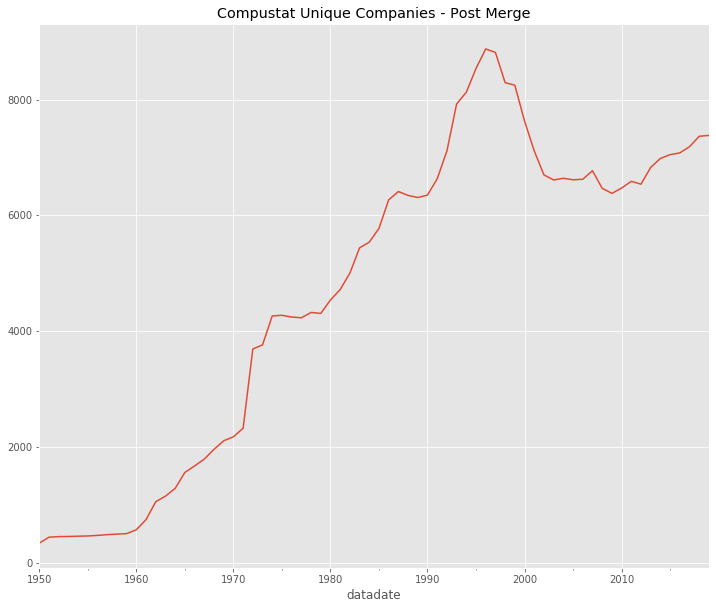

In [12]:
compa_df_ = pd.merge(temp_merge[temp_ids], 
                     compa_df,
                     how='inner',
                     on=['gvkey','datadate']).sort_values(by=['gvkey', 'datadate'])
compa_df_['datadate_mend'] = compa_df_['datadate'] + MonthEnd(0)

# CRSP Shares outstanding is in thousands, need to change to millions to be consistent with Compustat
compa_df_['shrout_adj'] = compa_df_['shrout_adj']/1000 
compa_df_['mcap'] = compa_df_['mcap']/1000

del temp_merge, temp_comp, temp_crsp
compa_df_.groupby(['datadate'])['gvkey'].count().groupby(pd.Grouper(freq='A')).sum().plot()
plt.title('Compustat Unique Companies - Post Merge')

**Calculating Profitability Variables**
- Gross profits over assets
- Return on equity
- Return on assets
- Cash flow over assets
- Gross margin
- Accrual

In [13]:
# calculate value of preferred share - order: redemption > liquidiation > par value
compa_df_['pfs'] = np.where(compa_df_['pstkrv'].isnull(),
                          compa_df_['pstkl'], 
                          compa_df_['pstkrv'])
compa_df_['pfs'] = np.where(compa_df_['pfs'].isnull(),
                          compa_df_['pstk'],
                          compa_df_['pfs'])
compa_df_['pfs'] = np.where(compa_df_['pfs'].isnull(), 
                           0, compa_df_['pfs'])

# To obtain shareholders’ equity, we use stockholders’ equity (SEQ),
# but if it is not available, we use the sum of common
# equity (CEQ) and preferred stock (PSTK).
# If both SEQ and CEQ are unavailable, we proxy shareholders’ equity
# by total assets (AT) minus the sum of total liability (LT) and minority interest (MIB)
compa_df_['seq'] = np.where(compa_df_['seq'].isnull(),
                           compa_df_['ceq'] + compa_df_['pstk'],
                           compa_df_['seq'])
compa_df_['seq'] = np.where(compa_df_['seq'].isnull(),
                           compa_df_['at'] - (compa_df_['lt'] + compa_df_['mib']),
                           compa_df_['seq'])

# calculate book value: shareholders equity plus balance sheet deferred taxes and
# investment tax credits minus preferred shares according to FASB 109,deferred tax credits are no
# longer included ib BE calculation post 2016 this was applied for all filings 1993 or later, 
# however I only make the adjustment post 2016 to avoid look ahead bias
compa_df_['be'] = (compa_df_['seq'] + compa_df_['txditc']*(~(compa_df_['year']>2016)) - compa_df_['pfs']).\
                            apply(lambda x: np.where(x <= 0, np.nan, x))

# Gross profits over assets
compa_df_['gpoa'] = (compa_df_['revt'] - compa_df_['cogs']).divide(compa_df_['at'], axis=0)

# return on equity
compa_df_['roe'] = compa_df_['ib'].divide(compa_df_['be'], axis=0)

# return on assets
compa_df_['roa'] = compa_df_['ib'].divide(compa_df_['at'], axis=0)

# working capital and change in working capital
compa_df_['wc'] = compa_df_['act'] - compa_df_['lct'] - compa_df_['che'] + compa_df_['dlc'] 
compa_df_['del_wc'] = compa_df_.groupby('gvkey')['wc'].diff(1)

# cashflow over assets
compa_df_['cf'] = compa_df_['ib'] + compa_df_['dp'] - compa_df_['del_wc'] - compa_df_['capx']
compa_df_['cfoa'] = compa_df_['cf'].divide(compa_df_['at'], axis=0)

# gross margin
compa_df_['gmar'] = (compa_df_['revt'] - compa_df_['cogs']).divide(compa_df_['sale'], axis=0)

# accrual
compa_df_['acc'] = -(compa_df_['del_wc'] - compa_df_['dp']).divide(compa_df_['at'], axis=0)

**Calculating Growth Variables**
- Gross profits over assets
- Return on equity
- Return on assets
- Cash flow over assets
- Gross margin
- Accrual

In [14]:
ff_rf = data.DataReader('F-F_Research_Data_Factors', 'famafrench',
                        start='1950-10-01')[0]['RF'].to_frame()*(12/100)

ff_rf['datadate_mend'] = pd.to_datetime(ff_rf.index.astype(str)) + MonthEnd(0)
compa_df_ = compa_df_.merge(ff_rf, how='left', on=['datadate_mend'])

compa_df_['gp'] = compa_df_['revt'] - compa_df_['cogs']

compa_df_[['gp_s', 'at_s', 'ib_s', 'be_s', 'cf_s','sale_s']] = \
            compa_df_[['gp', 'at', 'ib', 'be', 'cf','sale']].divide(compa_df_['shrout_adj'], axis=0)

compa_df_[['be_s_lag1', 'at_s_lag1']] = \
                compa_df_.groupby('gvkey')[['be_s', 'at_s']].shift(1)

compa_df_[['ib_s_lag5','be_s_lag5', 'cf_s_lag5', 'at_s_lag5', 'gp_s_lag5', 'sale_s_lag5']] = \
                compa_df_.groupby('gvkey')[['ib_s', 'be_s', 'cf_s', 'at_s', 'gp_s', 'sale_s']].shift(5)

compa_df_[['be_s_lag6', 'at_s_lag6']] = \
                compa_df_.groupby('gvkey')[['be_s', 'at_s']].shift(6)

# a simple wrapper to calculate the growth variables with less hassle
def calc_growth(df, num, den):
    
    numlag_5 = num + '_lag5'; denlag_1 = den + '_lag1'
    denlag_5 = den + '_lag5'; denlag_6 = den + '_lag6'
    
    return ((df[num] - df['RF'].multiply(df[denlag_1], axis=0)) -
            (df[numlag_5] - df['RF'].multiply(df[denlag_6], axis=0))).divide(df[denlag_5], axis=0)

compa_df_['del_gpoa'] = calc_growth(compa_df_, 'gp_s', 'at_s')
compa_df_['del_roe'] = calc_growth(compa_df_, 'ib_s', 'be_s')
compa_df_['del_roa'] = calc_growth(compa_df_, 'ib_s', 'at_s')
compa_df_['del_cfoa'] = calc_growth(compa_df_, 'cf_s', 'at_s')
compa_df_['del_gmar'] = (compa_df_['gp_s'] - compa_df_['gp_s_lag5']).divide(compa_df_['sale_s_lag5'])

**Preparing Quarterly Data**

In order to calculate `EVOL` or ROE volatility, I use quarterly compustat data and calculate quarterly roe similarly to annual roe.  

In [15]:
compq_df['gvkey'] = compq_df['gvkey'].astype(int)
compq_df['datadate'] = pd.to_datetime(compq_df['datadate'])
compq_df['datadate_mend'] = compq_df['datadate'] + MonthEnd(0)
compq_df.sort_values(['gvkey','datadate'], inplace=True)

# calculate value of preferred share - par value available only quarterly
compq_df['pfsq'] = np.where(compq_df['pstkq'].isnull(), 
                           0, compq_df['pstkq'])

compq_df['seqq'] = np.where(compq_df['seqq'].isnull(),
                           compq_df['ceqq'] + compq_df['pstkq'],
                           compq_df['seqq'])
compq_df['seqq'] = np.where(compq_df['seqq'].isnull(),
                           compq_df['atq'] - (compq_df['ltq'] + compq_df['mibq']),
                           compq_df['seqq'])

# calculate book value: shareholders equity plus balance sheet deferred taxes and
# investment tax credits minus preferred shares according to FASB 109,deferred tax credits are no
# longer included ib BE calculation post 2016 this was applied for all filings 1993 or later, 
# however I only make the adjustment post 2016 to avoid look ahead bias
compq_df['beq'] = (compq_df['seqq'] + compq_df['txditcq']*(~(compq_df['datadate_mend'] > '2016/08')) - compq_df['pfsq']).\
                            apply(lambda x: np.where(x <= 0, np.nan, x))
# calculating quarterly roe
compq_df['roeq'] = compq_df['ibq'].divide(compq_df['beq'], axis=0)

**Calculating Safety Variables**
- Beta against beta
- Leverage
- Ohlson's Score
- Altman's Z Score
- ROE Volatility

In [16]:
# bab
beta_dict = pd.read_pickle('monthly_beta_dict.pkl')
beta_df = pd.concat(beta_dict, axis=0, keys=beta_dict.keys()).reset_index()\
                    .rename(columns={'level_0': 'permno','level_1': 'datadate_mend'})
compa_df_ = compa_df_.merge(beta_df, how='left', on=['permno', 'datadate_mend'])
compa_df_['bab'] = -compa_df_['beta']

del beta_dict

# leverage
compa_df_['lev'] = -(compa_df_['dltt'] + compa_df_['dlc'] + compa_df_['mib'] + compa_df_['pstk']).divide(compa_df_['at'])

## ohlson's score
# adjusted asset
compa_df_['adjasset'] = compa_df_['at'] + 0.10*(compa_df_['mcap'] - compa_df_['be'])

# debt to assets
compa_df_['tlta'] = (compa_df_['dlc'] + compa_df_['dltt']).divide(compa_df_['adjasset'])

# working capital over assets
compa_df_['wcta'] = (compa_df_['act'] - compa_df_['lct']).divide(compa_df_['adjasset'])

# inverse current ratio
compa_df_['clca'] = compa_df_['lct'].divide(compa_df_['act'])

# OENEG
compa_df_['oeneg'] = np.where(compa_df_['lt'] > compa_df_['at'], 1, np.nan)
compa_df_['oeneg'] = np.where(compa_df_['lt'] <= compa_df_['at'], 0, compa_df_['oeneg'])

# net income over assets
compa_df_['nita'] = compa_df_['ib'].divide(compa_df_['at'])

# pretax income over liabilities
compa_df_['futl'] = compa_df_['pi'].divide(compa_df_['lt'])

# INTWO
compa_df_['ib_lag'] = compa_df_.groupby('gvkey')['ib'].shift(1)
compa_df_['intwo'] = compa_df_.groupby('gvkey').apply(lambda x: np.maximum(x['ib'], x['ib_lag'])).\
                            reset_index().drop(columns=['gvkey','level_1']).rename(columns={0: 'intwo'})

compa_df_['intwo_tag'] = np.where(compa_df_['intwo'] > 0, 0, np.nan)
compa_df_['intwo_tag'] = np.where(compa_df_['intwo'] < 0, 1, compa_df_['intwo_tag'])

# change in net income
compa_df_['chin'] = (compa_df_['ib'] - compa_df_['ib_lag']).divide((compa_df_['ib'].abs() + compa_df_['ib_lag'].abs()))

# cpi index
cpi_df = data.DataReader('CPIAUCSL', 'fred', start='1949-10-01')
ix_0 = compa_df_['datadate_mend'].min()
cpi_df.index = cpi_df.index + MonthEnd(-1)
cpi_df['CPI_reix'] = cpi_df['CPIAUCSL'].divide(cpi_df.loc[cpi_df.index == ix_0,'CPIAUCSL'].values[0], axis=0) # reindex
cpi_df['datadate_mend'] = cpi_df.index 
compa_df_ = compa_df_.merge(cpi_df[['datadate_mend','CPI_reix']], how='left', on='datadate_mend')

# log asset cpi
compa_df_['log_asset_cpi'] = np.log(compa_df_['adjasset'].divide(compa_df_['CPI_reix']))

# O-score
compa_df_['O_score'] = -(-1.32 - 0.407*compa_df_['log_asset_cpi'] + 6.03*compa_df_['tlta'] -
                         1.43*compa_df_['wcta'] + 0.076*compa_df_['clca'] - 1.72*compa_df_['oeneg'] -
                         2.37*compa_df_['nita'] - 1.83*compa_df_['futl'] + 0.285*compa_df_['intwo'] -
                         0.521*compa_df_['chin'])
# Altman Z score
compa_df_['Z_score'] = (1.2*compa_df_['wc'] + 1.4*compa_df_['re'] +
                        3.3*compa_df_['ebit'] + 0.6*compa_df_['mcap'] + 
                        compa_df_['sale']).divide(compa_df_['at'], axis=0)

# calculating quarterly roe volatility - 60 quarters rolling with minimum 12 quarters
roeq_vol = compq_df.groupby('gvkey')['roeq'].rolling(60, min_periods=12).std().reset_index()
roeq_vol.rename(columns={'roeq': 'roeq_vol'}, inplace=True)
roeq_vol['roeq_vol'] = roeq_vol['roeq_vol']*2 # annualizing by multiplying 2
compq_df['roeq_vol'] = roeq_vol['roeq_vol'].copy()

# merge back quarterly data with the annual data using gvkey and monthend dates
compa_df_ = compa_df_.merge(compq_df[['gvkey','datadate_mend','roeq_vol']],
                            how='left', on=['gvkey', 'datadate_mend'])
# Replace missing quarterly vol with annual volatility
compa_df_['roea_vol'] = compa_df_.groupby('gvkey')['roe'].rolling(5, min_periods=5).std().reset_index()['roe']
compa_df_['roe_vol'] = np.where(compa_df_['roeq_vol'].isnull(), compa_df_['roea_vol'], compa_df_['roeq_vol'])

**Calculating Payout Variables**
- Net equity issuance
- Net debt issuance
- Net payout over profits




In [17]:
# net equity issuance
compa_df_['log_shrout_adj'] = compa_df_['shrout_adj'].apply(np.log)
compa_df_['eiss'] = compa_df_.groupby('gvkey')['log_shrout_adj'].diff(1)*(-1)

# change in total debt
compa_df_['log_totd'] = (compa_df_['dltt'] + compa_df_['dlc'] + compa_df_['mib'] + compa_df_['pstk']).apply(np.log)
compa_df_['diss'] = compa_df_.groupby('gvkey')['log_totd'].diff(1)*(-1)

# netpayout over profits
compa_df_['del_be'] = compa_df_.groupby('gvkey')['be'].diff(1)
compa_df_['np'] = compa_df_['ib'].sub(compa_df_['del_be'], axis=0)
compa_df_['tnp'] = compa_df_.groupby('gvkey')['np'].rolling(5, min_periods=5).sum().reset_index()['np']
compa_df_['tgp'] = compa_df_.groupby('gvkey')['gp'].rolling(5, min_periods=5).sum().reset_index()['gp']
compa_df_['npop'] = compa_df_['tnp'].divide(compa_df_['tgp'])

# misc steps
compa_df_.drop(columns='permno',inplace=True)
ff_rf.drop(columns='datadate_mend', inplace=True)

S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\pandas\core\algorithms.py:1926: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


**Calculating Fama French Value weights for each portfolio formation period**

$$w_t = \frac{(1+ret_{t-1})...(1+ret_{t-\tau})ME_{0}}{\sum_{n}(1+ret_{t-1})...(1+ret_{t-\tau})ME_{0}} $$
- $ME_{0}$ is market cap as of end of june
- $(1+ret_{t-\tau})$ is market cap as of end of july

One thing to keep in mind, these weights will only apply if I am rebalancing annually, for monthly rebalancing the value weights will be based on the point in time lagged market capitalization of the stocks

Let's start by tagging the dates first, 


In [18]:
crsp_df__['year'] = crsp_df__['date_port'].dt.year
crsp_df__['month'] = crsp_df__['date_port'].dt.month
crsp_df__['date_ff'] = crsp_df__['date_port'] + MonthEnd(-select_month)
crsp_df__['year_ff'] = crsp_df__['date_ff'].dt.year
crsp_df__['month_ff'] = crsp_df__['date_ff'].dt.month

- Next we calculate the adjusted market capitalization, that is the numerator of the previous equation
- In the case of QMJ, we will use the lagged market cap as `mcap_adj` instead of the cumulative market cap from portfolio formation period as in fama french, since we are rebalancing every month instead of once a year. Using the FF approach will bias the result since the market cap calculated under that case will keep number of shares outstanding constant starting june every month. But what we need is for both price and quantity to change every month.  

In [19]:
crsp_df__['cum_ret'] = crsp_df__.groupby(['permno', 'year_ff'])['ret'].apply(lambda x: (1+x).cumprod())
crsp_df__['lag_cum_ret'] = crsp_df__.groupby(['permno'])['cum_ret'].shift(1)
crsp_df__['lag_mcap'] = crsp_df__.groupby('permno')['mcap'].shift(1)

crsp_df__['permno_count'] = crsp_df__.groupby('permno').cumcount()
crsp_df__['lag_mcap'].mask(crsp_df__['permno_count'] == 0, 
                           crsp_df__['mcap']/(1+crsp_df__['ret']), 
                           inplace=True)

mcap_base = crsp_df__.loc[crsp_df__['month_ff']==1,['permno', 'year_ff', 'lag_mcap']].\
                rename(columns={'lag_mcap': 'mcap_base'})

crsp_final_df = crsp_df__.merge(mcap_base, how='left', on=['permno', 'year_ff'])
crsp_final_df['mcap_adj'] = crsp_final_df['lag_mcap'].copy()
# np.where(crsp_final_df['month_ff'] == 1, 
#          crsp_final_df['lag_mcap'], 
#          crsp_final_df['mcap_base']*crsp_final_df['lag_cum_ret'])

**Let's also partition out a dataframe for the end of year market capitalization, can be used for variable calculation**

In [20]:
dec_mcap = crsp_final_df.loc[crsp_final_df['month']==12,:].copy()
dec_mcap.rename(columns = {'mcap':'dec_mcap'},inplace=True)
dec_mcap['year'] = dec_mcap['year'] + 1
dec_mcap = dec_mcap.loc[:,['permno','year','dec_mcap']].copy()

**Subset the CRSP data based on the formation date** 

In [21]:
crsp_mnth = pd.merge(crsp_final_df[crsp_final_df['month']==select_month].copy(), dec_mcap,
                     how='inner', on=['permno', 'year']).sort_values(['permno', 'date_port']).drop_duplicates()

**Merging Compustat with CRSP**

- First we inner join `ccm_df` with `compam_df` to get the permno for a given gvkey
- We use financial information up until the end of t-1 and form portfolios at June of year t, this gives us `date_me`
- Next we sort the dataframe based on whether the `date_me` within the linked date ranges to ensure the permnos being used is valid
- Inner join the CRSP final dataframe with the compustat file containing the permnos

In [22]:
compa_df__ = compa_df_.merge(ccm_df, how='left', on='gvkey')
compa_df__['year'] = compa_df__['datadate'].dt.year
compa_df__['datadate_mend'] = compa_df__['datadate'] + MonthEnd(0)
compa_df__['date_port'] = compa_df__['datadate'] + YearEnd(0) + MonthEnd(select_month)

linkdt_bnds = (compa_df__['date_port'] >= compa_df__['linkdt']) & (compa_df__['date_port'] <= compa_df__['linkenddt']) 

ccompa_month = pd.merge(crsp_mnth, compa_df__[linkdt_bnds], how='inner', 
                        on=['permno','date_port'], suffixes=('_crsp', '_comp'))
ccompa_month.sort_values(['permno','date_port'], inplace=True)

**Calculating post merge quality metrics**

- Calculate cross sectional rank for each sub component

$$r_{x} = rank(x)$$

- Transform rank into zscore for each sub component

$$z(x) = \frac{r_{x} - \hat{r_{x}}}{\sigma(r_{x})}$$
- Average all the zscores to get one single score for the main component
- Now, rank again the main component score cross sectionally 
- Finally, transform the main component ranks into z scores, for any main component $X$ with $n$ sub components
$$Z_{X} = z[(1/n)*\sum_{i}z_{x_{i}})]$$
- Now to get the final quality score repeat step 3 to 5
$$Quality = z[(1/3)*(Z_{profit}+Z_{safety}+Z_{growth}+Z_{payout})]$$


In [23]:
#Book to Market
#ccompa_month['bm'] = (ccompa_month['be']*1000)/ccompa_month['dec_mcap']

score_grouper = ccompa_month.groupby('date_port')

profrank_ids = ['gpoa_rank', 'roe_rank', 'roa_rank', 'cfoa_rank', 'gmar_rank', 'acc_rank']
growthrank_ids = ['delgpoa_rank', 'delroe_rank', 'delroa_rank', 'delcfoa_rank', 'delgmar_rank'] 
saferank_ids = ['bab_rank', 'lev_rank', 'oscore_rank', 'zscore_rank', 'roevol_rank']
porank_ids = ['eiss_rank', 'diss_rank', 'npop_rank']

ccompa_month[profrank_ids] = score_grouper['gpoa', 'roe', 'roa', 'cfoa', 'gmar', 'acc'].rank()
ccompa_month[growthrank_ids] = score_grouper['del_gpoa', 'del_roe', 'del_roa', 'del_cfoa', 'del_gmar'].rank()
ccompa_month[saferank_ids] = score_grouper['bab', 'lev', 'O_score', 'Z_score', 'roe_vol'].rank()
ccompa_month[porank_ids] = score_grouper['eiss', 'diss', 'npop'].rank()

ccompa_month['profit'] = score_grouper[profrank_ids].apply(lambda x: (x - x.mean())/x.std()).mean(axis=1)
ccompa_month['growth'] = score_grouper[growthrank_ids].apply(lambda x: (x - x.mean())/x.std()).mean(axis=1)
ccompa_month['safety'] = score_grouper[saferank_ids].apply(lambda x: (x - x.mean())/x.std()).mean(axis=1)
ccompa_month['payout'] = score_grouper[porank_ids].apply(lambda x: (x - x.mean())/x.std()).mean(axis=1)

ccompa_month['rank_profit'] = score_grouper['profit'].rank()
ccompa_month['Z_profit'] = score_grouper['rank_profit'].apply(lambda x: (x - x.mean())/x.std())

ccompa_month['rank_growth'] = score_grouper['growth'].rank()
ccompa_month['Z_growth'] = score_grouper['rank_growth'].apply(lambda x: (x - x.mean())/x.std())

ccompa_month['rank_safety'] = score_grouper['safety'].rank()
ccompa_month['Z_safety'] = score_grouper['rank_safety'].apply(lambda x: (x - x.mean())/x.std())

ccompa_month['rank_payout'] = score_grouper['payout'].rank()
ccompa_month['Z_payout'] = score_grouper['rank_payout'].apply(lambda x: (x - x.mean())/x.std())

# final quality score
ccompa_month['quality'] = ccompa_month[['Z_profit', 'Z_growth', 'Z_safety', 'Z_payout']].mean(axis=1)
ccompa_month['rank_quality'] = score_grouper['quality'].rank()
ccompa_month['Z_quality'] = score_grouper['rank_quality'].apply(lambda x: (x - x.mean())/x.std())

S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # This is added back by InteractiveShellApp.init_path()
S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  if sys.path[0] == '':
S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]
S:\Users\sheha\anaconda3\envs\sentinel_prime\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [50]:
ccompa_month[['Z_profit', 'Z_growth', 'Z_safety', 'Z_quality']].corr()

,Z_profit,Z_growth,Z_safety,Z_quality
Z_profit,1.000000,0.268552,0.160536,0.672384
Z_growth,0.268552,1.000000,0.061111,0.594441
Z_safety,0.160536,0.061111,1.000000,0.594141
Z_quality,0.672384,0.594441,0.594141,1.000000


**Merge back with monthly returns to get full time series**

AQR rebalances QMJ on a monthly basis. So we need the signals to take effect end of every month instead of once a portfolio formation date per year.

In [35]:
portann_df = ccompa_month[['date', 'permno', 'date_port', 'Z_quality']].copy()
portann_df['year_ff'] = portann_df['date_port'].dt.year

strat_cols2 = ['date', 'permno', 'permno_count', 'shrcd', 'exchcd', 'ret_final',
               'mcap','mcap_adj', 'cum_ret', 'year_ff', 'date_port']
strat_cols1 = ['permno', 'year_ff', 'Z_quality']
portmnth_df = pd.merge(crsp_final_df[strat_cols2], portann_df[strat_cols1], how='left', on=['permno','year_ff'])

**Getting the NYSE Breakpoints**

Conditions for the breakpoints:
- Exchange code 1
- Share code 10 and 11
- positive market cap
- at least 2 years in compustat

In [36]:
nyse_ix = (portmnth_df['mcap'] > 0) & (portmnth_df['exchcd'] == 1) & \
         ((portmnth_df['shrcd'] == 10) | (portmnth_df['shrcd'] == 11)) & (portmnth_df['permno_count'] >= 23)
port_ix = (portmnth_df['mcap'] > 0) & (portmnth_df['permno_count'] >= 23)

# size_grouper = portmnth_df[nyse_ix].groupby('date_port')
# nyse_szbucket = size_grouper['mcap'].median().reset_index().\
#                 rename(columns={'mcap':'nyse_median'})

ff_meb = (data.DataReader('ME_Breakpoints', 'famafrench', start='1920-10-01')[0].iloc[:,1:]*1000).shift(1).dropna()
ff_meb.index = pd.to_datetime(ff_meb.index.astype(str)) + MonthEnd(0)

nyse_szbucket = pd.DataFrame()
nyse_szbucket['nyse_median'] = ff_meb[(45,50)].reset_index(drop=True).copy()
nyse_szbucket['date_port'] = ff_meb.index

portmnth_df = portmnth_df.merge(nyse_szbucket, how='left', on='date_port')

def szbucket(x):
    if np.isnan(x['mcap_adj']):
        return ''
    elif x['mcap_adj'] <= x['nyse_median']:
        return 'S'
    else: return 'B'

portmnth_df['szbucket'] = np.where(port_ix, portmnth_df.apply(szbucket, axis=1), '')

**Conditional Sorting**

For each portfolio formation date and size bucket, Use `Z_quality` to conditional sort by quality score.
Using 30th and 70th percentiles. 

In [37]:
prcntiles = [0.30, 0.70]

nyse_qbucket = portmnth_df[nyse_ix].groupby(['date_port','szbucket'])['Z_quality'].\
                                    describe(percentiles=prcntiles).reset_index()[['date_port','szbucket','30%', '70%']]
portmnth_df = portmnth_df.merge(nyse_qbucket, how='left', on=['date_port','szbucket'])
portmnth_df.rename(columns={'30%':'f30', '70%':'f70'},inplace=True)

def qbucket(x):
    if (x['Z_quality'] <= x['f30']):
        return 'J'
    elif (x['Z_quality'] > x['f30']) & (x['Z_quality'] <= x['f70']):
        return 'M'
    elif (x['Z_quality'] > x['f70']):
        return 'Q'
    else: return ''

portmnth_df['qbucket'] = np.where(port_ix, portmnth_df.apply(qbucket, axis=1), '')
portmnth_df['posq_tag'] = np.where(port_ix, 1, 0)
portmnth_df['q_tag'] = np.where(portmnth_df['qbucket'] == '', 0, 1)

# Keeping observations with available and positive mcap, positive market cap and under `shrcd` 10 and 11 
portmnth_ix = (portmnth_df['mcap_adj'] > 0) & (portmnth_df['posq_tag'] == 1) & (portmnth_df['q_tag'] == 1) & \
                ((portmnth_df['shrcd'] == 10) | (portmnth_df['shrcd'] == 11))
portmnth_df = portmnth_df[portmnth_ix]

In [26]:
# portann_df = ccompa_month[['date', 'permno', 'date_port','szbucket', 'qbucket', 'posq_tag', 'q_tag']]
# portann_df['year_ff'] = portann_df['date_port'].dt.year

# strat_cols1 = [ 'permno', 'year_ff','szbucket', 'qbucket', 'posq_tag', 'q_tag']
# strat_cols2 = ['date', 'permno', 'shrcd', 'exchcd', 'ret_final', 'mcap','mcap_adj', 'cum_ret', 'year_ff', 'date_port']

# portmnth_df = pd.merge(crsp_final_df[strat_cols2], portann_df[strat_cols1], how='left', on=['permno','year_ff'])
# portmnth_ix = (portmnth_df['mcap_adj'] > 0) & (portmnth_df['posq_tag'] == 1) & (portmnth_df['q_tag'] == 1) & \
#                 ((portmnth_df['shrcd'] == 10) | (portmnth_df['shrcd'] == 11))
# portmnth_df = portmnth_df[portmnth_ix]

**Calculate the value weighted return**

Simple value weighted return using `mcap_adj`

In [38]:
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

vw_ret_df = portmnth_df.groupby(['date_port', 'szbucket', 'qbucket']).apply(wavg, 'ret_final', 'mcap_adj').\
                    reset_index().rename(columns={0: 'vw_ret'})
vw_ret_df.head(10)

,date_port,szbucket,qbucket,vw_ret
0,1951-07-31,B,J,0.071453
1,1951-07-31,B,M,0.086652
2,1951-07-31,B,Q,0.071723
3,1951-07-31,S,J,0.063927
4,1951-07-31,S,M,0.047111
5,1951-07-31,S,Q,0.067157
6,1951-08-31,B,J,0.054947
7,1951-08-31,B,M,0.055992
8,1951-08-31,B,Q,0.039744
9,1951-08-31,S,J,0.071169


**Lets calculate the returns for conditional size sorted portfolios and the QMJ factor**

$$QMJ = (1/2)*(SQ - SJ) + (1/2)*(BQ - BJ)$$
- SQ = Small Quality
- SJ = Small Junk
- BQ = Big Quality
- BJ = Big Junk


In [39]:
vw_ret_df['port_ids'] = vw_ret_df['szbucket'] + vw_ret_df['qbucket']
qmj_factors = vw_ret_df.pivot_table(values='vw_ret',index='date_port', columns='port_ids').reset_index()
qmj_factors['QMJ'] = (qmj_factors['BQ'] + qmj_factors['SQ'])/2 - (qmj_factors['BJ'] + qmj_factors['SJ'])/2
qmj_factors.index = qmj_factors['date_port']
qmj_factors.drop('date_port', axis=1)
qmj_factors.describe()

port_ids,BJ,BM,BQ,SJ,SM,SQ,QMJ
count,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000
mean,0.008271,0.010115,0.011156,0.010294,0.012677,0.013250,0.002920
std,0.047144,0.043338,0.039594,0.066235,0.055743,0.052527,0.017432
min,-0.229982,-0.213363,-0.203058,-0.323571,-0.275529,-0.283007,-0.085803
25%,-0.017312,-0.014345,-0.011940,-0.026302,-0.016710,-0.017436,-0.007597
50%,0.010858,0.012757,0.013012,0.014080,0.015870,0.014162,0.003212
75%,0.036154,0.037444,0.037050,0.048730,0.043702,0.044425,0.013233
max,0.181638,0.169615,0.166710,0.317706,0.293594,0.260026,0.064680


**Let's add the fama french risk free rate and calculate excess returns for the size sorted portfolios**

In [40]:
qmj_ports = ['BJ', 'BM', 'BQ', 'SJ', 'SM', 'SQ']
ff_rf.index =  pd.to_datetime(ff_rf.index.astype(str)) + MonthEnd(0)
qmj_factors = pd.concat([qmj_factors, ff_rf], axis=1).dropna()
qmj_factors['RF'] = qmj_factors['RF']/12
qmj_factors[qmj_ports] = qmj_factors[qmj_ports].sub(qmj_factors['RF'], axis=0)

Text(0.5, 1.0, '2 X 3 Portfolios - Quality Replication - at 10% Vol')

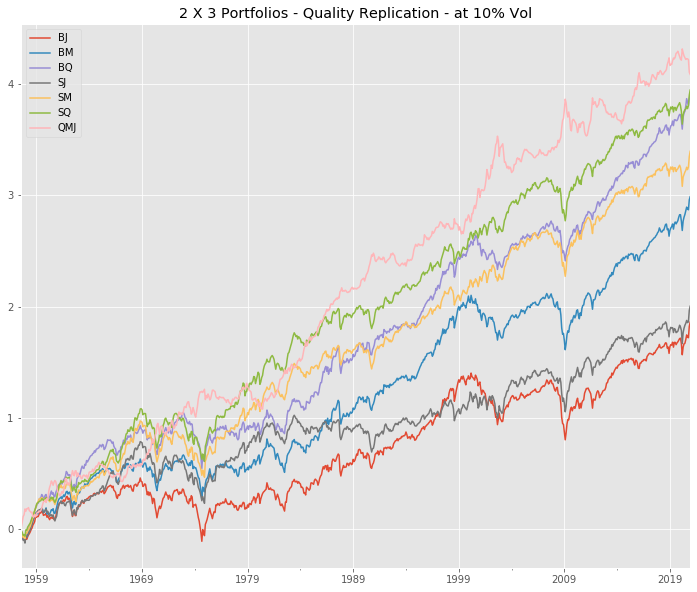

In [41]:
qmj_factors.loc['1957/07':, ['BJ', 'BM', 'BQ', 'SJ', 'SM', 'SQ', 'QMJ']].\
                        apply(lambda x: x*(0.10/(x.std()*3.46))).cumsum().plot()
plt.title('2 X 3 Portfolios - Quality Replication - at 10% Vol')

In [45]:
qmj_factors[['BJ', 'BM', 'BQ', 'SJ', 'SM', 'SQ', 'QMJ']].corr()

,BJ,BM,BQ,SJ,SM,SQ,QMJ
BJ,1.000000,0.953599,0.911225,0.859713,0.864746,0.853077,-0.665813
BM,0.953599,1.000000,0.934921,0.827758,0.836155,0.831859,-0.546959
BQ,0.911225,0.934921,1.000000,0.792023,0.810015,0.808575,-0.382227
SJ,0.859713,0.827758,0.792023,1.000000,0.973323,0.959819,-0.717757
SM,0.864746,0.836155,0.810015,0.973323,1.000000,0.980904,-0.621335
SQ,0.853077,0.831859,0.808575,0.959819,0.980904,1.000000,-0.552559
QMJ,-0.665813,-0.546959,-0.382227,-0.717757,-0.621335,-0.552559,1.000000


**Robustness Check**

I do a simple robustness check by running the following regression:

$$QMJ_{t} = \alpha + \gamma_{mkt}MKT_t{t} + \gamma_{smb}SMB_t{t} + \gamma_{hml}HML_t{t} + \gamma_{cma}CMA_t{t} + \gamma_{rmw}RMW_t{t} + \gamma_{umd}UMD_t{t} + \epsilon_{t}$$

As evidenced in the original paper, our QMJ factor also has large positive loading on the RMW factor, as well as negative loadings on market, size and value. The alpha is also significant at 5% level.

In [46]:
ff_factors = data.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', '1920-01-01')[0]/100
mom_factor = data.DataReader('F-F_Momentum_Factor', 'famafrench', '1920-01-01')[0]/100
ff_factors.drop(columns='RF', inplace=True)
ff_factors.index =  pd.to_datetime(ff_factors.index.astype(str)) + MonthEnd(0)
mom_factor.index =  pd.to_datetime(mom_factor.index.astype(str)) + MonthEnd(0)
ff_factors = pd.concat([ff_factors, mom_factor], axis=1)

In [47]:
model = sm.OLS(qmj_factors.loc['1963/07':'2016/12','QMJ'], 
               sm.add_constant(ff_factors.loc['1963/07':'2016/12',:]), 
               missing='drop').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    QMJ   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     184.8
Date:                Sun, 14 Mar 2021   Prob (F-statistic):          1.06e-135
Time:                        16:46:19   Log-Likelihood:                 2005.7
No. Observations:                 642   AIC:                            -3997.
Df Residuals:                     635   BIC:                            -3966.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.000      7.093      0.000       0.002       0.004
Mkt-RF        -0.1688      0.011    -15.351      0.000      -0.190      -0.147
SMB           -0.0586      0.015     -3.844      0.000      -0.089      -0.029
HML           -0.2105      0.022     -9.664      0.000      -0.253      -0.168
RMW            0.3350      0.021     15.847      0.000       0.293       0.376
CMA            0.1573      0.031      4.998      0.000       0.096       0.219
Mom            0.0896      0.010      8.548      0.000       0.069       0.110
==============================================================================
Omnibus:                       12.834   Durbin-Watson:                   1.810
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               21.855
Skew:                           0.091   Prob(JB):                     1.80e-05
Kurtosis:                       3.886   Cond. No.                         85.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
qmj_factors.loc['1957/07':,['SJ', 'SM', 'SQ', 'BJ', 'BM', 'BQ', 'QMJ']].to_clipboard()